In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from preprocessing import one_hot_encode_columns

In [58]:
data_file = "data/hour.csv"
df = pd.read_csv(data_file)
df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [59]:
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
target_columns = ["cnt"]

df = df[feature_columns + target_columns]
df.describe()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [60]:
df = one_hot_encode_columns(df, column_names=categorical_columns)
df = df[["cnt"]]
df["cnt"] = df["cnt"] / 100

In [61]:
scaler = StandardScaler()
scaler.fit(df["cnt"].to_numpy().reshape(-1, 1))
#df["cnt"] = scaler.transform(df["cnt"].to_numpy().reshape(-1, 1))

StandardScaler()

In [62]:
inputs = df.to_numpy()[:-1]
labels = df[target_columns].to_numpy()[1:]

print(f"Inputs have shape: {inputs.shape}")
print(f"Labels have shape: {labels.shape}")

Inputs have shape: (17378, 1)
Labels have shape: (17378, 1)


In [63]:
def baseline_model(vec):
    return vec[:, 0]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.2, random_state=9, shuffle=True)

In [65]:
X_train.shape

(13902, 1)

In [66]:
linear_regressor = LinearRegression().fit(X_train, y_train)

In [67]:
model_predictions = linear_regressor.predict(X_test)
mean_squared_error(y_test, model_predictions, squared=False)

0.9859979600835569

In [68]:
baseline_predictions = baseline_model(X_test)
mean_squared_error(y_test, baseline_predictions, squared=False)

1.024975469127434

Text(0, 0.5, 'Prediction')

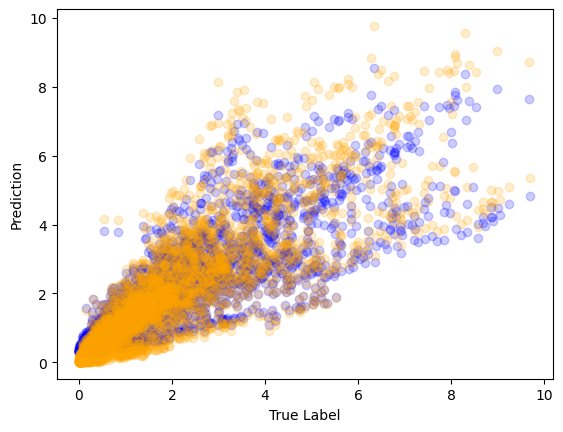

In [69]:
fig, ax = plt.subplots()

ax.scatter(y_test, model_predictions, alpha=0.2, color="blue")
ax.scatter(y_test, baseline_predictions, alpha=0.2, color="orange")
ax.set_xlabel("True Label")
ax.set_ylabel("Prediction")

In [70]:
import torch
from torch.utils.data import DataLoader

from nn_dataprep import BikeshareDataset

In [71]:
"""
shuffled_df = df.sample(frac=1, random_state=9)
train_set_size = int(len(shuffled_df) * 0.8)

train_set = shuffled_df.iloc[:train_set_size, :]
test_set = shuffled_df.iloc[train_set_size:, :]
"""

'\nshuffled_df = df.sample(frac=1, random_state=9)\ntrain_set_size = int(len(shuffled_df) * 0.8)\n\ntrain_set = shuffled_df.iloc[:train_set_size, :]\ntest_set = shuffled_df.iloc[train_set_size:, :]\n'

In [72]:
train_data = BikeshareDataset(X_train, y_train)
test_data = BikeshareDataset(X_test, y_test)

In [73]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [75]:
from torch import nn

In [89]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [90]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [91]:
learning_rate = .01
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [92]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if np.isnan(X.numpy()).any():
            print("hi")
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)
            
    error /= num_batches
    print(f"Test RMAE: {error}")

In [93]:
epochs = 500
for t in range(epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer)
    if t % 100 == 0:
        print(t)
        test_loop(test_dataloader, model, loss_fn)
print("Done!")


0
Test RMAE: 0.9743110916831277
100
Test RMAE: 0.9535161874511026
200
Test RMAE: 0.9515449903228066
300
Test RMAE: 0.9504250374707308
400
Test RMAE: 0.9495599746704102
Done!


In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)